## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/Seq05VD_f02820.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0016E5_08029.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0006R0_f01710.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_08019_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/Seq05VD_f03930_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_08039_P.png')]

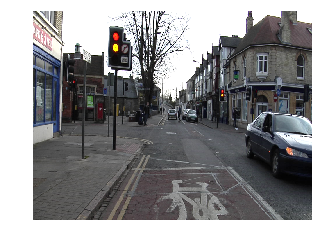

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

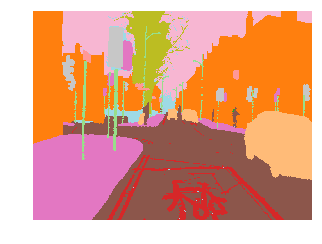

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [17]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [18]:
size = src_size//2
bs=8

In [20]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [21]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

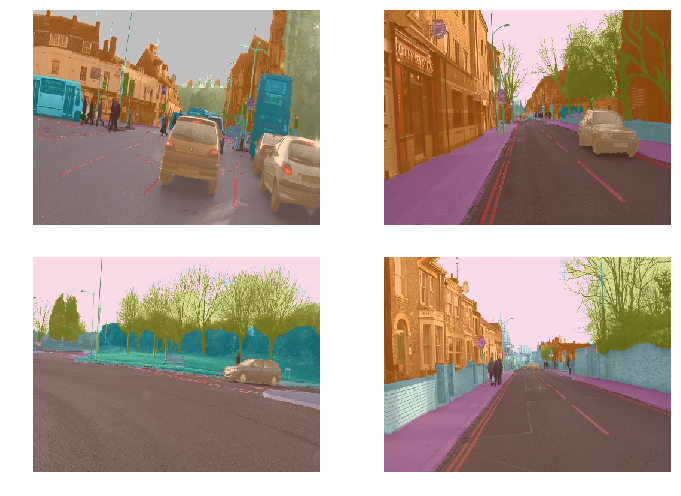

In [22]:
data.show_batch(2, figsize=(10,7))

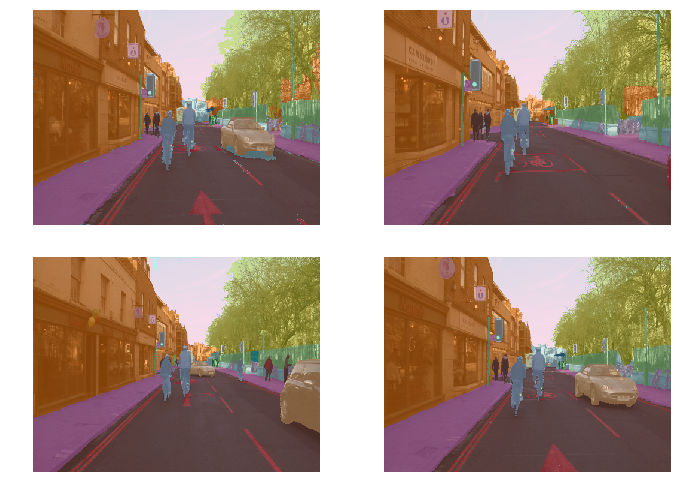

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [27]:
metrics=acc_camvid
# metrics=accuracy

In [28]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


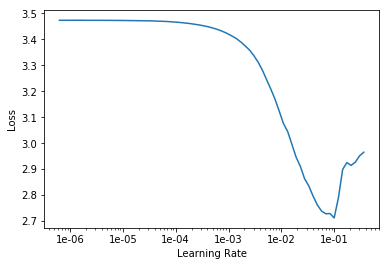

In [29]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=1e-2

In [31]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:38
epoch  train_loss  valid_loss  acc_camvid
1      1.552554    1.291037    0.724980    (00:58)
2      0.895283    0.549260    0.864284    (00:50)
3      0.746147    0.618884    0.839610    (00:51)
4      0.665129    0.803522    0.808047    (00:51)
5      0.599735    0.468424    0.874690    (00:51)
6      0.546238    0.435708    0.879287    (00:51)
7      0.498956    0.408863    0.877468    (00:51)
8      0.461538    0.371375    0.893120    (00:51)
9      0.426086    0.361540    0.893572    (00:51)
10     0.406867    0.352902    0.896628    (00:51)



In [32]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

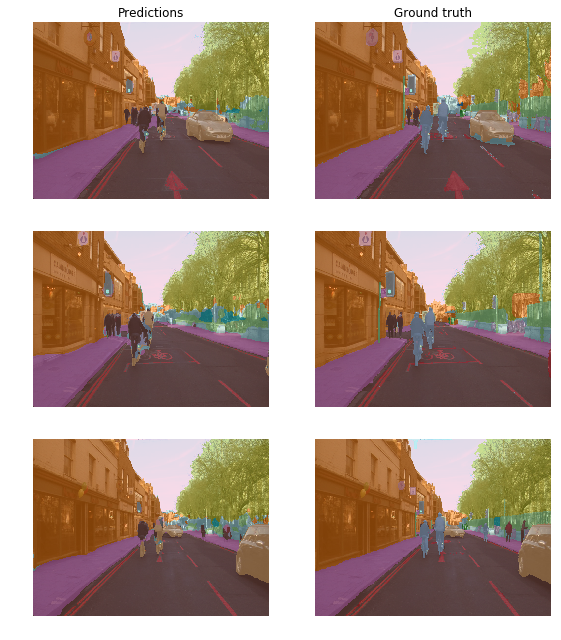

In [33]:
learn.show_results()

In [34]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


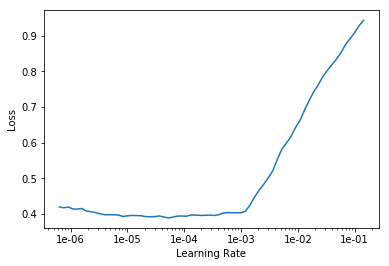

In [35]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lrs = slice(1e-5,lr/5)

In [37]:
learn.fit_one_cycle(12, lrs)

Total time: 11:42
epoch  train_loss  valid_loss  acc_camvid
1      0.408993    0.344269    0.899875    (00:57)
2      0.413072    0.353707    0.893455    (00:58)
3      0.411512    0.364298    0.892403    (00:58)
4      0.411542    0.373978    0.885958    (00:58)
5      0.404747    0.350243    0.900411    (00:58)
6      0.397071    0.367097    0.893761    (00:58)
7      0.378853    0.354849    0.893255    (00:58)
8      0.361258    0.297376    0.915533    (00:58)
9      0.348360    0.304707    0.911930    (00:58)
10     0.333286    0.304768    0.912278    (00:58)
11     0.324351    0.303310    0.913124    (00:58)
12     0.326836    0.303280    0.913028    (00:58)



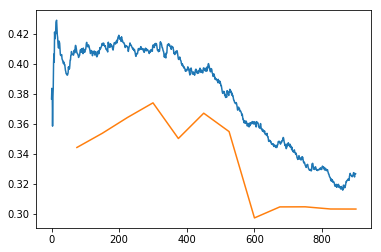

In [38]:
learn.recorder.plot_losses()

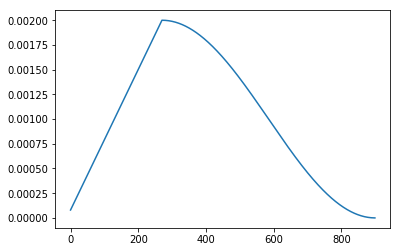

In [39]:
learn.recorder.plot_lr()

In [40]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [41]:
size = src_size
bs=4

In [42]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [43]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [44]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


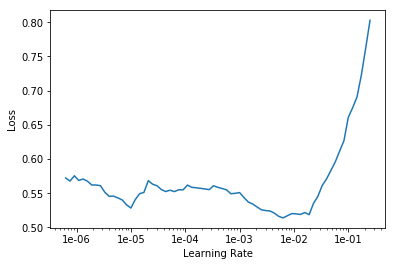

In [45]:
lr_find(learn)
learn.recorder.plot()

In [46]:
lr=1e-3

In [47]:
learn.fit_one_cycle(10, slice(lr))

Total time: 33:11
epoch  train_loss  valid_loss  acc_camvid
1      0.473699    0.370349    0.893978    (03:33)
2      0.417912    0.337739    0.903886    (03:16)
3      0.401205    0.353703    0.898462    (03:17)
4      0.389604    0.356120    0.896095    (03:17)
5      0.371003    0.329490    0.907102    (03:18)
6      0.352914    0.336497    0.907762    (03:18)
7      0.333043    0.332548    0.909168    (03:18)
8      0.326214    0.322739    0.912374    (03:17)
9      0.317482    0.323972    0.913512    (03:16)
10     0.323949    0.323305    0.912774    (03:17)



In [48]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [49]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:30
epoch  train_loss  valid_loss  acc_camvid
1      0.323283    0.300749    0.915948    (00:56)
2      0.329482    0.290447    0.918337    (00:56)
3      0.324378    0.298494    0.920271    (00:57)
4      0.316414    0.296469    0.918053    (00:56)
5      0.305226    0.284694    0.920893    (00:57)
6      0.301774    0.306676    0.914202    (00:57)
7      0.279722    0.285487    0.919991    (00:57)
8      0.269306    0.285219    0.920963    (00:57)
9      0.260325    0.284758    0.922026    (00:57)
10     0.251017    0.285375    0.921562    (00:57)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

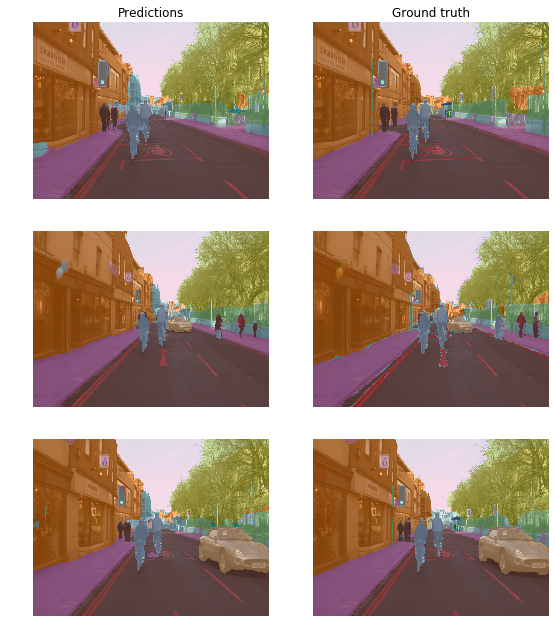

In [ ]:
learn.show_results()